In [18]:
# Core data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from collections import Counter

# NLP libraries for basic text analysis
import nltk
import textstat

# Basic text processing
import re
import string

print("Libraries imported successfully")

Libraries imported successfully


In [19]:
# Configuration and display settings
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

# Basic configuration
RANDOM_STATE = 42

# Download required NLTK data
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt", quiet=True)

try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords", quiet=True)

try:
    nltk.data.find("taggers/averaged_perceptron_tagger")
except LookupError:
    nltk.download("averaged_perceptron_tagger", quiet=True)

print("Configuration complete")

Configuration complete


# Load Data

Load the training and test datasets containing essays with their prompts and scoring rubrics.

In [20]:
# Load training and test datasets
train = pd.read_csv('df_train.csv')
test = pd.read_csv('df_test.csv')

print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print(f"\nTraining columns: {list(train.columns)}")
print(f"Test columns: {list(test.columns)}")

Training data shape: (9912, 6)
Test data shape: (473, 2)

Training columns: ['prompt', 'essay', 'task_achievement', 'coherence_and_cohesion', 'lexical_resource', 'grammatical_range']
Test columns: ['prompt', 'essay']


### Datasets Overview

- **Datasets**: Two datasets were loaded: a training set (`df_train.csv`) and a test set (`df_test.csv`).
- **Data Shape**: 
    - Training data: 9,912 entries with 6 columns.
    - Test data: 473 entries with 2 columns.
- **Columns**:
    - Training set: Includes `prompt`, `essay`, and four scoring metrics: `task_achievement`, `coherence_and_cohesion`, `lexical_resource`, and `grammatical_range`.
    - Test set: Contains only the `prompt` and `essay` columns.

# Exploratory Data Analysis (EDA)

Let's explore the structure and characteristics of our dataset to understand the data better before preprocessing.

In [21]:
# Display basic information about training data
print("=== Training Data Info ===")
train.info()
print(f"\nFirst few rows:")
print(train.head())

=== Training Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   prompt                  9912 non-null   object 
 1   essay                   9912 non-null   object 
 2   task_achievement        9667 non-null   float64
 3   coherence_and_cohesion  9614 non-null   float64
 4   lexical_resource        9238 non-null   float64
 5   grammatical_range       9041 non-null   float64
dtypes: float64(4), object(2)
memory usage: 464.8+ KB

First few rows:
                                              prompt  \
0  Young people who commit crimes should be treat...   
1  Young people who commit crimes should be treat...   
2  Young people who commit crimes should be treat...   
3  Young people who commit crimes should be treat...   
4  Young people who commit crimes should be treat...   

                                   

In [22]:
# Display basic information about test data
print("=== Test Data Info ===")
test.info()
print(f"\nFirst few rows:")
print(test.head())

=== Test Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   prompt  473 non-null    object
 1   essay   473 non-null    object
dtypes: object(2)
memory usage: 7.5+ KB

First few rows:
                                              prompt  \
0  In many countries, more and more young people ...   
1  Some believe that people are naturally born le...   
2  Every day, millions of tons of food are wasted...   
3  some people think that the best way to solve g...   
4  Some people think the best way to solve global...   

                                               essay  
0  Unemployment in young generation is one of the...  
1  The pie chart illustrates the rates of destina...  
2  Each day tons of food is being wasted in many ...  
3  There can be little doubt that the only way to...  
4  At one point in time, the government tried to ...  


Available target columns: ['task_achievement', 'coherence_and_cohesion', 'lexical_resource', 'grammatical_range']

=== Target Variables Summary ===
       task_achievement  coherence_and_cohesion  lexical_resource  \
count       9667.000000             9614.000000       9238.000000   
mean           6.621599                6.677502          6.205726   
std            1.132620                1.369647          1.083939   
min            0.000000                0.000000          0.000000   
25%            6.500000                6.000000          6.000000   
50%            7.000000                7.000000          6.500000   
75%            7.000000                7.500000          7.000000   
max            9.000000                9.000000          8.000000   

       grammatical_range  
count        9041.000000  
mean            6.130461  
std             1.122422  
min             0.000000  
25%             6.000000  
50%             6.500000  
75%             7.000000  
max           

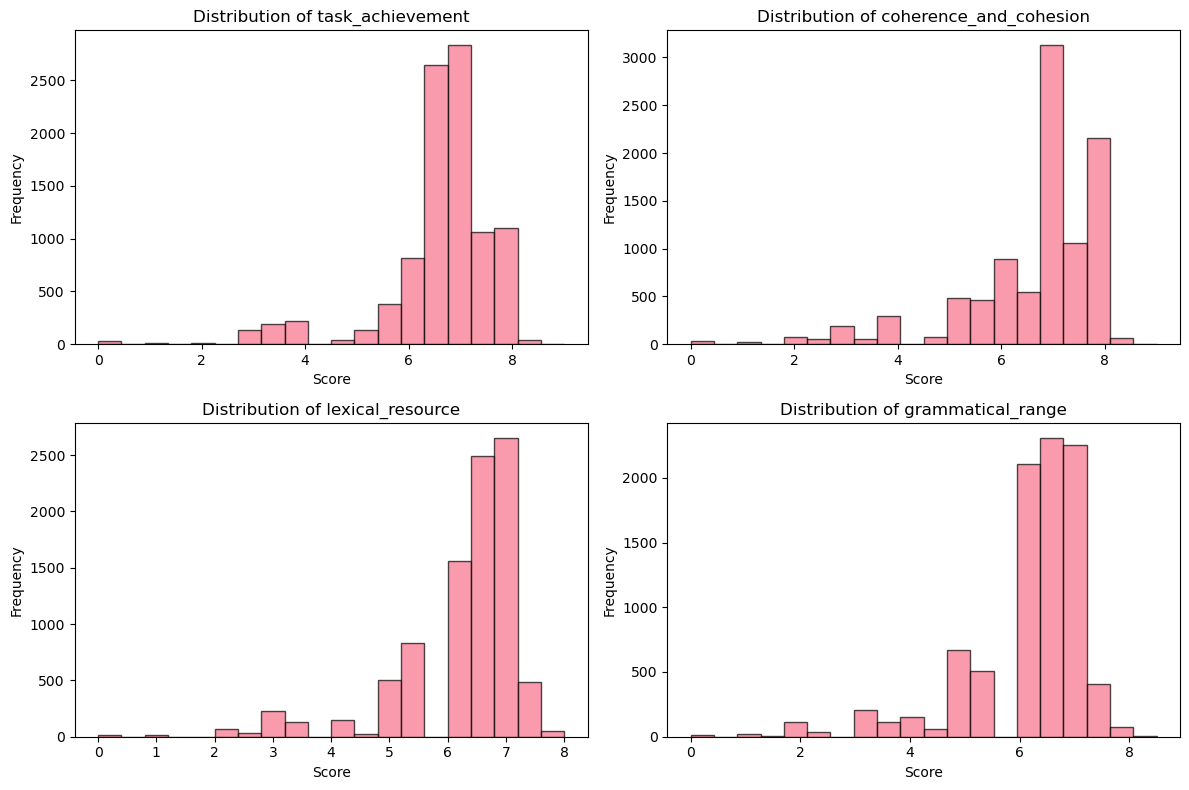

In [23]:
# Analyze target variables distribution
target_cols = ['task_achievement', 'coherence_and_cohesion', 'lexical_resource', 'grammatical_range']

# Check if target columns exist in training data
available_targets = [col for col in target_cols if col in train.columns]
print(f"Available target columns: {available_targets}")

if available_targets:
    # Statistical summary of target variables
    print("\n=== Target Variables Summary ===")
    print(train[available_targets].describe())
    
    # Distribution plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()
    
    for i, col in enumerate(available_targets):
        if i < 4:
            axes[i].hist(train[col].dropna(), bins=20, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel('Score')
            axes[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

<Figure size 1200x600 with 0 Axes>

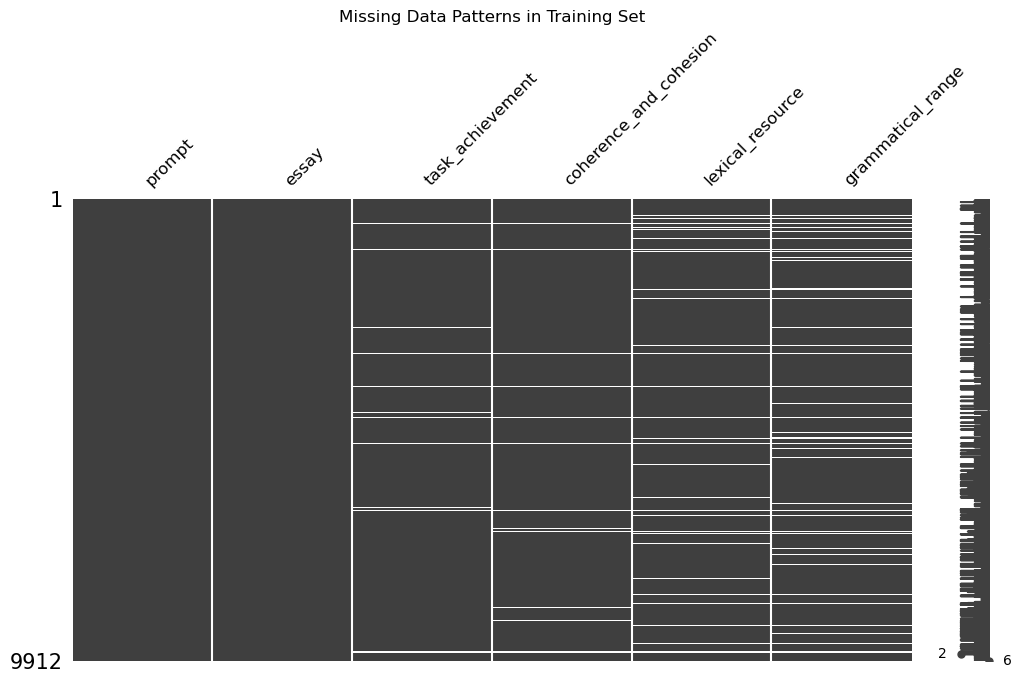


=== Missing Data Summary ===
                        Missing Count  Missing Percentage
grammatical_range                 871            8.787328
lexical_resource                  674            6.799839
coherence_and_cohesion            298            3.006457
task_achievement                  245            2.471751


In [24]:
# Visualize missing data patterns
plt.figure(figsize=(12, 6))
msno.matrix(train, figsize=(12, 6), fontsize=12)
plt.title('Missing Data Patterns in Training Set')
plt.show()

# Missing data summary
missing_data = train.isnull().sum()
missing_percent = (missing_data / len(train)) * 100
missing_summary = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)

print("\n=== Missing Data Summary ===")
print(missing_summary[missing_summary['Missing Count'] > 0])

=== Text Statistics ===
Average word count: 292.8
Average character count: 1799.9
Average sentence count: 13.6


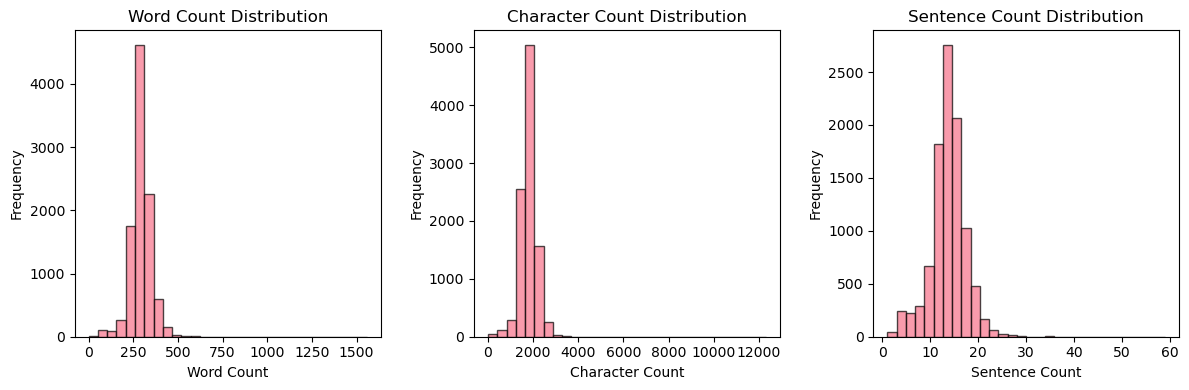

In [25]:
# Text analysis - basic statistics
if 'essay' in train.columns:
    train['word_count'] = train['essay'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
    train['char_count'] = train['essay'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
    train['sentence_count'] = train['essay'].apply(lambda x: len(nltk.sent_tokenize(str(x))) if pd.notna(x) else 0)
    
    print("=== Text Statistics ===")
    print(f"Average word count: {train['word_count'].mean():.1f}")
    print(f"Average character count: {train['char_count'].mean():.1f}")
    print(f"Average sentence count: {train['sentence_count'].mean():.1f}")
    
    # Text length distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.hist(train['word_count'], bins=30, alpha=0.7, edgecolor='black')
    plt.title('Word Count Distribution')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.hist(train['char_count'], bins=30, alpha=0.7, edgecolor='black')
    plt.title('Character Count Distribution')
    plt.xlabel('Character Count')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 3)
    plt.hist(train['sentence_count'], bins=30, alpha=0.7, edgecolor='black')
    plt.title('Sentence Count Distribution')
    plt.xlabel('Sentence Count')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

=== Correlation Between Scoring Dimensions ===
                        task_achievement  coherence_and_cohesion  \
task_achievement                1.000000                0.917756   
coherence_and_cohesion          0.917756                1.000000   
lexical_resource                0.920673                0.929900   
grammatical_range               0.910629                0.928796   

                        lexical_resource  grammatical_range  
task_achievement                0.920673           0.910629  
coherence_and_cohesion          0.929900           0.928796  
lexical_resource                1.000000           0.946609  
grammatical_range               0.946609           1.000000  


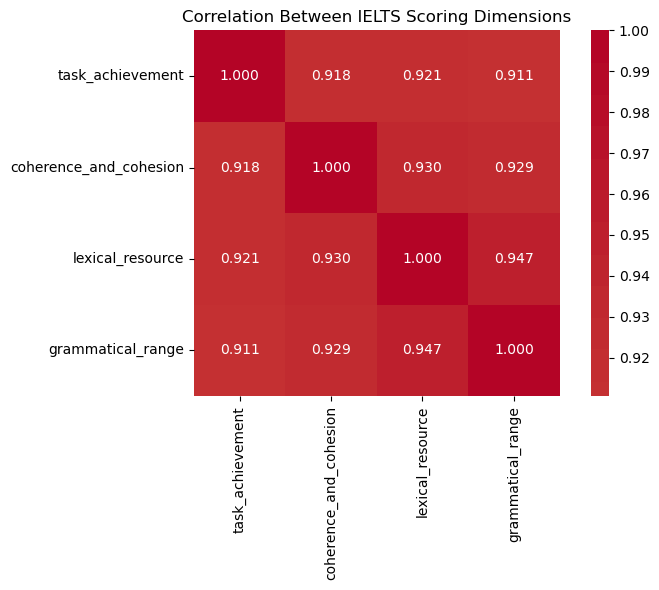

<Figure size 1000x800 with 0 Axes>

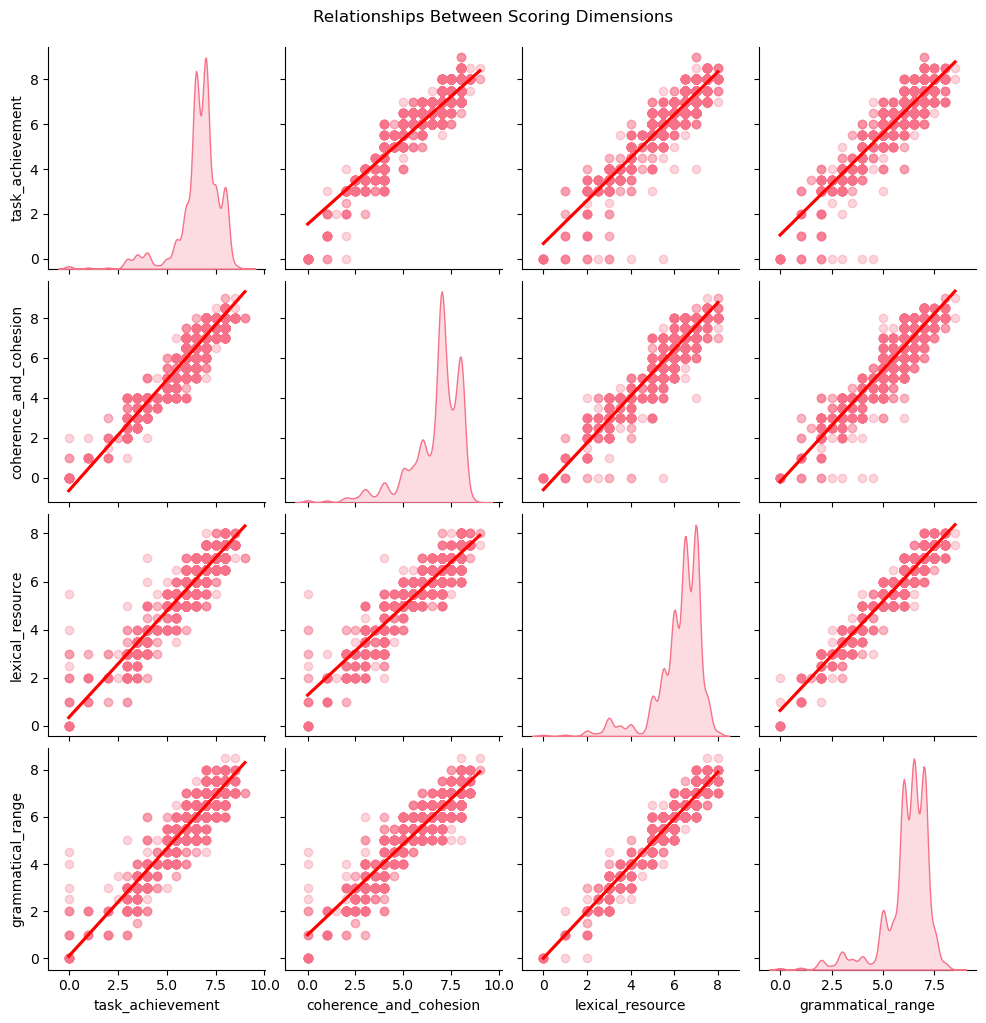

In [26]:
# Analyze relationships between scoring dimensions
if available_targets and len(available_targets) > 1:
    print("=== Correlation Between Scoring Dimensions ===")
    correlation_matrix = train[available_targets].corr()
    print(correlation_matrix)
    
    # Correlation heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.3f')
    plt.title('Correlation Between IELTS Scoring Dimensions')
    plt.tight_layout()
    plt.show()
    
    # Pairplot for scoring dimensions
    plt.figure(figsize=(10, 8))
    sns.pairplot(train[available_targets], diag_kind='kde', kind='reg',
                plot_kws={'scatter_kws': {'alpha': 0.3}, 'line_kws': {'color': 'red'}})
    plt.suptitle('Relationships Between Scoring Dimensions', y=1.02)
    plt.show()